<a href="https://colab.research.google.com/github/Kaguya2906/Anomaly_Detection_Weekly_Project/blob/main/07.AutoEncoder%2CIForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I'll cover two Python outlier detection methods.

Firstly, I'll introduce the autoencoder structure and show you how to build the anomaly scores. I’ll dive into the components of a deep learning model that the autoencoder is based on. These components include the concept of batch size, L1 and L2 regularization, epochs, the optimizer in a deep learning model, and so on.

Then, I'll talk about Isolation Forest, a method works rather than profiling normal data points in order to find outliers, but identifies anomalies directly. It applies a tree structure to isolate every observation. Anomalies will be the data points first to be singled out; whereas normal points tend to hide deep in the tree. They call each tree the Isolation Tree or iTree. Their algorithm builds an ensemble of iTrees. Anomalies are those observations that have short average path lengths on the iTrees.


# Libraries, Dataset

In [ ]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185331 sha256=1286b5502d0a77d13dcb910d935eeb1ada1559691264e6bf2a012ccd6b3c62d2
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Autoencoder
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
#from pyod.utils.data import evaluate_print
#from pyod.utils.example import visualize

#IForest
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
df.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,4851.44


# (A)AutoEncoders

An autoencoder is a special type of neural network that copies the input values to the output values. Because it does not require the target variable like a standard neural network model, it is categorized as unsupervised learning.
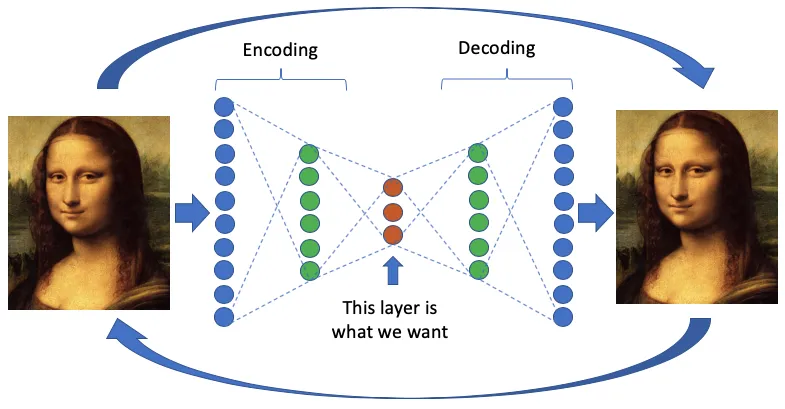

## Train-Test Split

In [ ]:
contamination = 0.1  # percentage of outliers

# Split the data into training and test sets using train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Convert the training and test data to pandas DataFrames
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)

When you do unsupervised learning, it is always a safe step to standardize the predictors

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [ ]:
X_train.shape

(130452, 15)

In [ ]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,1.304520e+05,1.304520e+05,1.304520e+05,1.304520e+05,1.304520e+05,1.304520e+05,1.304520e+05,1.304520e+05,1.304520e+05,1.304520e+05,130452.0,130452.0,130452.0,130452.0,130452.0
mean,1.198291e-17,8.088461e-17,2.941259e-17,7.462082e-17,5.403201e-17,6.263792e-17,1.606799e-17,7.750761e-17,-7.861058e-17,6.655959e-17,0.0,0.0,0.0,0.0,0.0
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.0,0.0,0.0,0.0,0.0
min,-1.620211e+00,-1.683845e+00,-6.170590e-01,-9.171230e-01,-1.004051e+00,-8.967105e-01,-1.043528e+00,-9.106910e-01,-1.039100e+00,-6.149666e-01,0.0,0.0,0.0,0.0,0.0
25%,-9.594865e-01,-7.419227e-01,-5.006344e-01,-5.840929e-01,-5.890218e-01,-6.030765e-01,-5.503081e-01,-6.091986e-01,-5.447628e-01,-6.149666e-01,0.0,0.0,0.0,0.0,0.0
50%,-3.592219e-02,-1.289218e-01,-3.065934e-01,-3.255364e-01,-3.197945e-01,-3.372562e-01,-2.979973e-01,-3.296442e-01,-2.952413e-01,-6.149666e-01,0.0,0.0,0.0,0.0,0.0
75%,8.226351e-01,8.936536e-01,1.202969e-01,2.057912e-01,2.137885e-01,2.504507e-01,1.601785e-01,2.637786e-01,1.555405e-01,1.626105e+00,0.0,0.0,0.0,0.0,0.0
max,2.736969e+00,1.866635e+00,6.481358e+01,1.908637e+01,1.996544e+01,8.079003e+00,1.806812e+01,8.001555e+00,1.367859e+01,1.626105e+00,0.0,0.0,0.0,0.0,0.0


## Autoencoder
* You do not need the target variable to train the unsupervised learning model.
* We will build three models: clf1, clf2, and clf3
* clf1 has hidden_neurons = [25, 2, 2, 25]
* clf2 has hidden_neurons = [25, 10, 2, 10, 25]
* clf3 has hidden_neurons = [25, 15, 10, 2, 10, 15, 25])
* The number of the hidden layers and the number of neutrons in a hidden layer: if there are too many hidden layers or too many neutrons, the model tends to overfit; otherwise the model tends to underfit.


### Model 1

In [ ]:
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1.fit(X_train)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 15)                240       
                                                                 
 dropout_28 (Dropout)        (None, 15)                0         
                                                                 
 dense_33 (Dense)            (None, 15)                240       
                                                                 
 dropout_29 (Dropout)        (None, 15)                0         
                                                                 
 dense_34 (Dense)            (None, 25)                400       
                                                                 
 dropout_30 (Dropout)        (None, 25)                0         
                                                                 
 dense_35 (Dense)            (None, 2)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7efc2a7e7ac0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

#### Outlier labels

In [ ]:
# get the prediction on the test data
y_test_pred = clf1.predict(X_test)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf1.decision_function(X_test)  # outlier scores

y_test_pred = pd.Series(y_test_pred)
y_test_scores = pd.Series(y_test_scores)

1020/1020 [==============================] - 1s 1ms/step


In [ ]:
y_test_pred.value_counts()

0    29317
1     3296
dtype: int64

#### Visualization

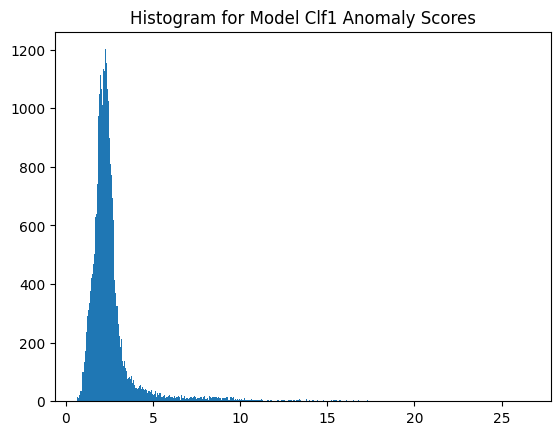

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

#### Describe the outliers
* We recommend observations in Cluster 1 to be outliers.
* The attributes of Cluster 1 are shown below.

In [ ]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

0    29943
1     2670
Name: cluster, dtype: int64

In [ ]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,score
cluster,,,,,,,,,,,,,,,,
0,0.007143,0.000016,-0.071029,-0.210141,-0.208885,-0.215518,-0.206594,-0.214138,-0.205215,-0.018955,0.0,0.0,0.0,0.0,0.0,2.223152
1,-0.080108,-0.000179,0.796559,2.356651,2.342567,2.416954,2.316876,2.401469,2.301410,0.212576,0.0,0.0,0.0,0.0,0.0,7.252691


### Model 2

In [ ]:
clf2 = AutoEncoder(hidden_neurons =[25, 10,2, 10, 25])
clf2.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 15)                240       
                                                                 
 dropout_34 (Dropout)        (None, 15)                0         
                                                                 
 dense_40 (Dense)            (None, 15)                240       
                                                                 
 dropout_35 (Dropout)        (None, 15)                0         
                                                                 
 dense_41 (Dense)            (None, 25)                400       
                                                                 
 dropout_36 (Dropout)        (None, 25)                0         
                                                                 
 dense_42 (Dense)            (None, 10)               

#### Visualization

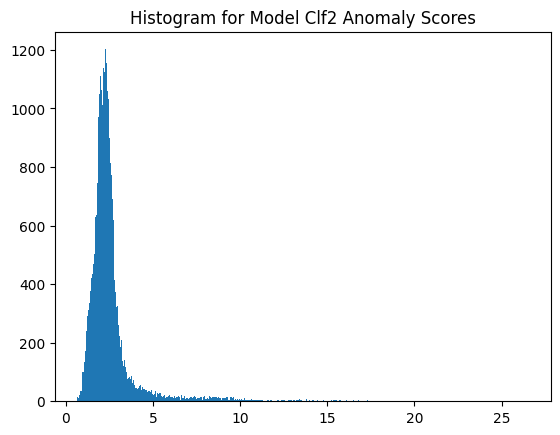

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

0    29943
1     2670
Name: cluster, dtype: int64

#### Describe the outliers


In [ ]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,score
cluster,,,,,,,,,,,,,,,,
0,0.007143,0.000016,-0.071029,-0.210141,-0.208885,-0.215518,-0.206594,-0.214138,-0.205215,-0.018955,0.0,0.0,0.0,0.0,0.0,2.223076
1,-0.080108,-0.000179,0.796559,2.356651,2.342567,2.416954,2.316876,2.401469,2.301410,0.212576,0.0,0.0,0.0,0.0,0.0,7.252854


### Model 3

In [ ]:
clf3 = AutoEncoder(hidden_neurons =[25, 15, 10, 2, 10,15, 25])
clf3.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 15)                240       
                                                                 
 dropout_41 (Dropout)        (None, 15)                0         
                                                                 
 dense_48 (Dense)            (None, 15)                240       
                                                                 
 dropout_42 (Dropout)        (None, 15)                0         
                                                                 
 dense_49 (Dense)            (None, 25)                400       
                                                                 
 dropout_43 (Dropout)        (None, 25)                0         
                                                                 
 dense_50 (Dense)            (None, 15)               

#### Visualization

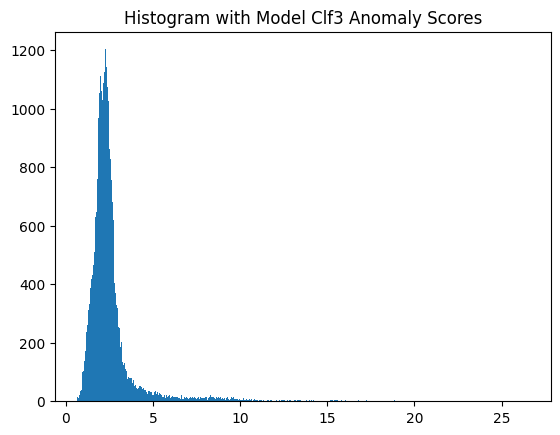

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

0    29943
1     2670
Name: cluster, dtype: int64

#### Describe the outliers

In [ ]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,score
cluster,,,,,,,,,,,,,,,,
0,0.007143,0.000016,-0.071029,-0.210141,-0.208885,-0.215518,-0.206594,-0.214138,-0.205215,-0.018955,0.0,0.0,0.0,0.0,0.0,2.223091
1,-0.080108,-0.000179,0.796559,2.356651,2.342567,2.416954,2.316876,2.401469,2.301410,0.212576,0.0,0.0,0.0,0.0,0.0,7.252892


## Achieve Model Stability by Aggregating Multiple Models

* Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.

* The solution is to train multiple models then aggregate the scores.
4
* There are four methods to aggregate the outcome:
5
* (1) Average: average scores of all detectors.
6
* (2) Maximum of Maximum (MOM)
7
* (3) Average of Maximum (AOM)
8
* (4) Maximum of Average (MOA)

In [ ]:
pip install combo

In [ ]:
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test)
                            })

1020/1020 [==============================] - 1s 1ms/step


In [ ]:
train_scores.head()

,clf1,clf2,clf3
0,6.615360,6.615616,6.615500
1,1.643182,1.642913,1.643151
2,1.762318,1.762210,1.762182
3,2.787354,2.787112,2.787346
4,1.526431,1.526107,1.526204


In [ ]:
test_scores.head()

,clf1,clf2,clf3
0,3.328889,3.328899,3.329117
1,3.050546,3.050791,3.050488
2,2.116337,2.116028,2.116120
3,1.668861,1.668566,1.668802
4,2.748703,2.748513,2.748638


In [ ]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
from sklearn.preprocessing import StandardScaler
train_scores_norm = StandardScaler().fit_transform(train_scores)
test_scores_norm = StandardScaler().fit_transform(test_scores)

In [ ]:
train_scores_norm.shape

(130452, 3)

### Average
The "average" function in PyOD averages the outlier scores from multiple estimators.
See [PyOD API Reference](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn).

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)
y_by_average[1:10]

array([ 0.23775496, -0.2966608 , -0.55254252,  0.06504489, -0.62632645,
       -0.02968965, -0.44507409, -0.2479458 , -0.35670351])

#### Visualization

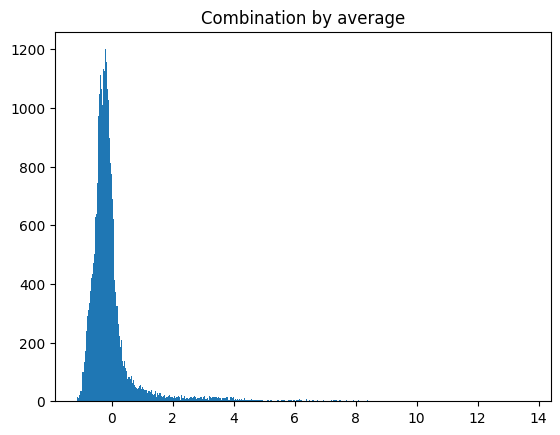

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)

import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

It appears we can identify those >=2.0 as the outliers

In [ ]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']>2, 0, 1)
df_test['y_by_average_cluster'].value_counts()

1    31269
0     1344
Name: y_by_average_cluster, dtype: int64

#### Describe the outliers

In [ ]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,
0,-0.082015,-0.027273,0.653850,3.379743,3.376907,3.500869,3.352146,3.499636,3.353585,0.177846,0.0,0.0,0.0,0.0,0.0,4.006907
1,0.003525,0.001172,-0.028104,-0.145268,-0.145146,-0.150474,-0.144082,-0.150421,-0.144143,-0.007644,0.0,0.0,0.0,0.0,0.0,-0.172224


### Maximum of maximum
Merge the outlier scores from multiple estimators by taking the maximum.

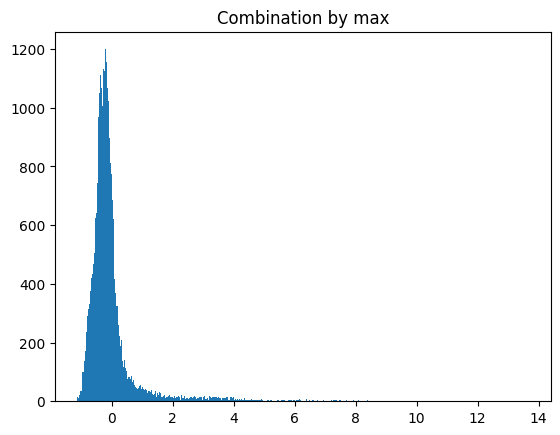

In [ ]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)

import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

Similarly, it appears we can identify those >=2.0 as the outliers

In [ ]:
df_test = X_test.copy()
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']>2, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

1    31269
0     1344
Name: y_by_maximization_cluster, dtype: int64

#### Describe the outliers

In [ ]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,
0,-0.082015,-0.027273,0.653850,3.379743,3.376907,3.500869,3.352146,3.499636,3.353585,0.177846,0.0,0.0,0.0,0.0,0.0,4.006907,0.0,4.006963
1,0.003525,0.001172,-0.028104,-0.145268,-0.145146,-0.150474,-0.144082,-0.150421,-0.144143,-0.007644,0.0,0.0,0.0,0.0,0.0,-0.172224,1.0,-0.172139


# (B)IForest

Isolation Forest is fast and does not consume much memory because it does not use any distance measures to detect anomalies. This advantage makes it suitable for large data sizes and high-dimensional problems.

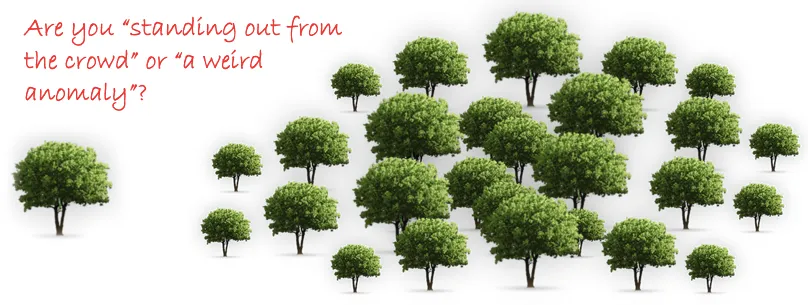

## Train-Test Split

In [ ]:
contamination = 0.1  # percentage of outliers

# Split the data into training and test sets using train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Convert the training and test data to pandas DataFrames
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)

### Standardize

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

## IForest
* You do not need the target variable to train the unsupervised learning model.
* We will create three models: clf1, clf2,and clf3
* Model 1: max_samples = 100000
* Model 2: max_samples = 50000
* Model 3: max_samples = 30000

### Model 1

In [ ]:
clf1 = IForest(behaviour="new", max_samples=100000)
clf1.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=100000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

* After modeling, there is an anomaly score for each observation in the training dataset X_Train.

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.037316
1    0.026513
2   -0.070760
3   -0.073618
4   -0.029122
dtype: float64

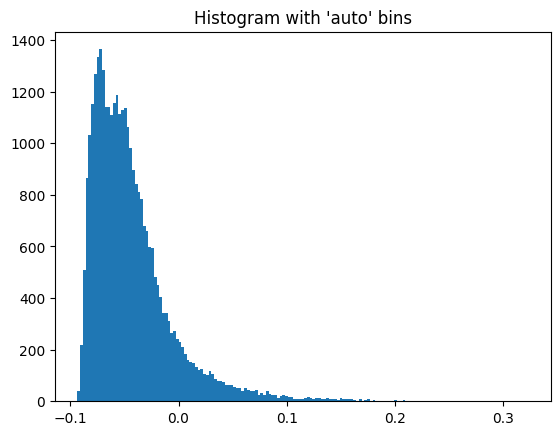

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

* We will identify the outliers as a cluster and demonstrate the X attributes
* A high anomaly score means more abnormal. We can suggest those >=0.1 to be outliers

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']>0.1, 0, 1)
X_test_cluster['cluster'].value_counts()

1    32287
0      326
Name: cluster, dtype: int64

In [ ]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,distance
cluster,,,,,,,,,,,,,,,,
0,-0.196402,0.057139,0.271027,4.611585,4.577374,4.322335,5.006887,4.321169,5.002199,0.458316,0.0,0.0,0.0,0.0,0.0,0.142532
1,0.001983,-0.000577,-0.002737,-0.046563,-0.046217,-0.043642,-0.050554,-0.043631,-0.050507,-0.004628,0.0,0.0,0.0,0.0,0.0,-0.045403


* We recommend observations in Cluster 1 to be outliers. The average "distance" indicates the distances of those points in Cluster 1. The distance of Cluster 1 is higher than that of Cluster 0, meaning points in Cluster 1 are far away from other points.

### Model 2

In [ ]:
clf2 = IForest(behaviour="new", max_samples=50000)
clf2.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=50000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.031370
1    0.049480
2   -0.065239
3   -0.079454
4   -0.056090
dtype: float64

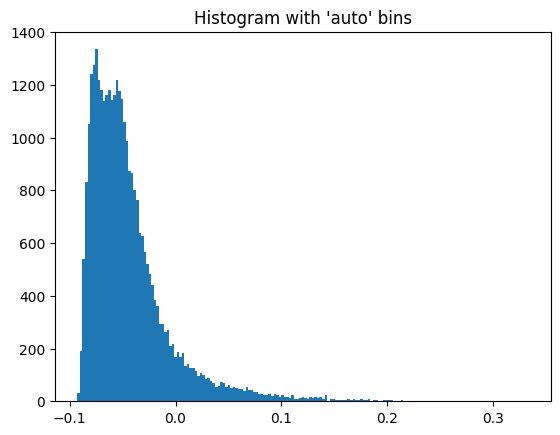

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']>0.1, 0, 1)
X_test_cluster['cluster'].value_counts()

1    32201
0      412
Name: cluster, dtype: int64

In [ ]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,distance
cluster,,,,,,,,,,,,,,,,
0,-0.152344,0.050352,0.359404,4.476991,4.453567,4.249786,4.888464,4.255303,4.932334,0.430274,0.0,0.0,0.0,0.0,0.0,0.144106
1,0.001949,-0.000644,-0.004598,-0.057281,-0.056982,-0.054374,-0.062546,-0.054445,-0.063107,-0.005505,0.0,0.0,0.0,0.0,0.0,-0.046367


### Model 3

In [ ]:
clf3 = IForest(behaviour="new", max_samples=30000)
clf3.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=60, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.042202
1   -0.006209
2   -0.125023
3   -0.150398
4   -0.107506
dtype: float64

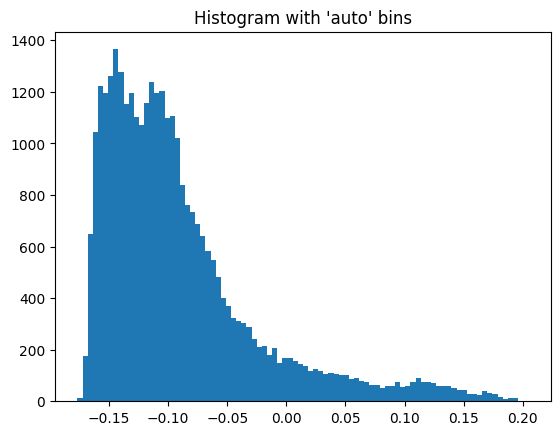

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']>0.15, 0, 1)
X_test_cluster['cluster'].value_counts()

1    32349
0      264
Name: cluster, dtype: int64

In [ ]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,distance
cluster,,,,,,,,,,,,,,,,
0,-0.382278,0.368180,-0.302745,5.327922,5.391395,5.332824,6.124661,5.386638,6.358056,0.294156,0.0,0.0,0.0,0.0,0.0,0.169632
1,0.003120,-0.003005,0.002471,-0.043481,-0.043999,-0.043521,-0.049983,-0.043960,-0.051888,-0.002401,0.0,0.0,0.0,0.0,0.0,-0.092476


## Achieve Model Stability by Aggregating Multiple Models
* Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
* The solution is to train multiple models then aggregate the scores.
* There are four methods to aggregate the outcome:
* (1) Average: average scores of all detectors.
* (2) Maximum of Maximum (MOM)
* (3) Average of Maximum (AOM)
* (4) Maximum of Average (MOA)

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

Put all the predictions in a data frame

In [ ]:
# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test)
                            })

In [ ]:
train_scores.head()

,clf1,clf2,clf3
0,0.049960,0.082165,0.089487
1,-0.076370,-0.078959,-0.163915
2,-0.066826,-0.065945,-0.128053
3,0.016228,0.004819,-0.074675
4,-0.084800,-0.080844,-0.163204


In [ ]:
test_scores.head()

,clf1,clf2,clf3
0,-0.037316,-0.031370,-0.042202
1,0.026513,0.049480,-0.006209
2,-0.070760,-0.065239,-0.125023
3,-0.073618,-0.079454,-0.150398
4,-0.029122,-0.056090,-0.107506


In [ ]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
from sklearn.preprocessing import StandardScaler
train_scores_norm = StandardScaler().fit_transform(train_scores)
test_scores_norm = StandardScaler().fit_transform(test_scores)

In [ ]:
train_scores_norm.shape

(130452, 3)

### Average

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)
y_by_average[1:10]

array([ 1.81562632, -0.58877996, -0.85933954, -0.06167471, -0.94650542,
       -0.18591303, -0.34268341, -0.06711275, -0.60624256])

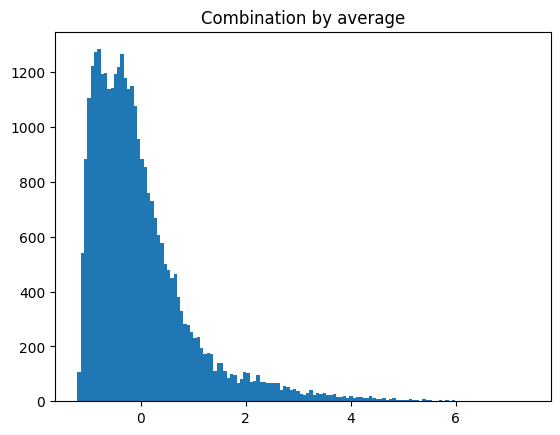

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)

import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

It appears we can identify those >=4 as the outliers

In [ ]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<4, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    32372
1      241
Name: y_by_average_cluster, dtype: int64

In [ ]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,
0,0.001500,-0.000401,0.000875,-0.039401,-0.039081,-0.036474,-0.042982,-0.036530,-0.043285,-0.003251,0.0,0.0,0.0,0.0,0.0,-0.035070
1,-0.201519,0.053873,-0.117554,5.292489,5.249530,4.899349,5.773497,4.906894,5.814214,0.436686,0.0,0.0,0.0,0.0,0.0,4.710716


### Maximum of Maximum

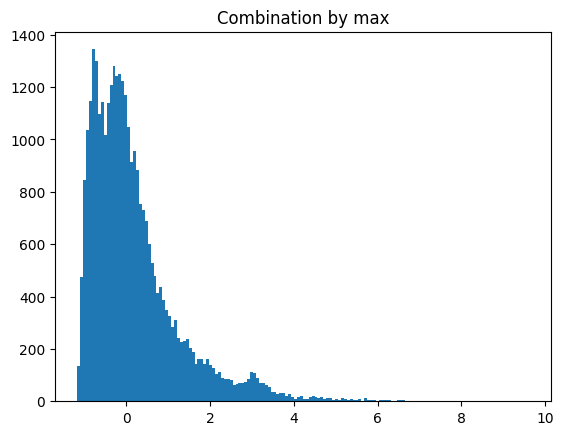

In [ ]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)

import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

It appears we can identify those >=4 as the outliers

In [ ]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<4, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    32282
1      331
Name: y_by_maximization_cluster, dtype: int64

In [ ]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,
0,0.002419,-0.001099,-0.003412,-0.047841,-0.047469,-0.044773,-0.052777,-0.044823,-0.052996,-0.004672,0.0,0.0,0.0,0.0,0.0,-0.045556,0.000000,0.143795
1,-0.235922,0.107219,0.332733,4.665874,4.629615,4.366667,5.147284,4.371570,5.168591,0.455656,0.0,0.0,0.0,0.0,0.0,4.443048,0.728097,5.065481
